In [1]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *

sim_name = f"no_gravity"
sim_folder = f"sim_output/{sim_name}"
fig_folder = f"figures_local/{sim_name}"
Cl_folder = f"Shared/Cls"
Delta_folder = f"Shared/Deltas"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)

## Overdensity band

ic| tot_dens_halos.shape: (1, 50)
ic| tot_dens_halos_PFs.shape: (1, 3)


[0.99978463 0.99989333 0.99994336 0.99996482 0.99997335 0.99997649
 0.99997754 0.99997787 0.99997796 0.99997798]
[0.00131422 0.00137476 0.00143436]


ValueError: x and y must have same first dimension, but have shapes (5,) and (3,)

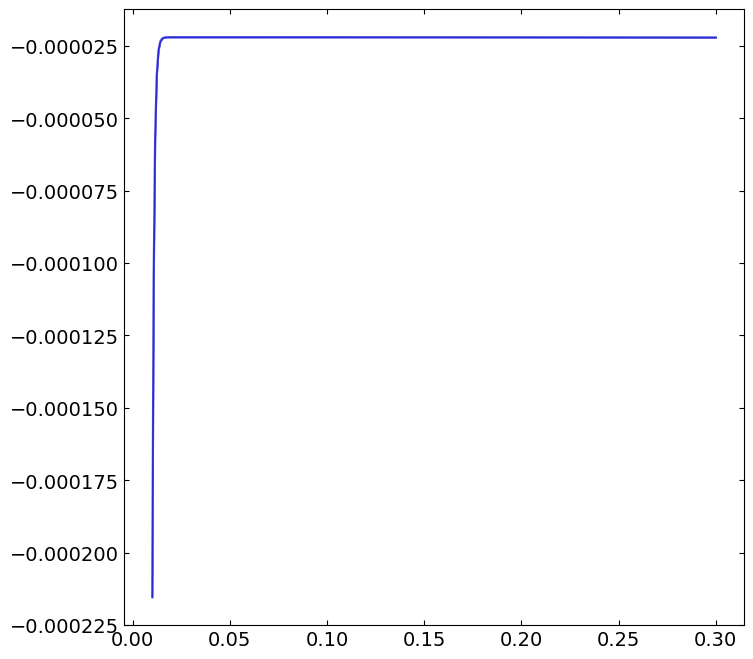

In [2]:
tot_dens_halos = jnp.load(f"{sim_folder}/total_densities.npy")
ic(tot_dens_halos.shape)

tot_dens_halos_PFs = jnp.load(f"{sim_folder}/total_densities_incl_PFs.npy")
ic(tot_dens_halos_PFs.shape)


eta = 2*1e-0
SimPlot.overdensity_band(
    dens_FD=tot_dens_halos,
    dens_PF=tot_dens_halos_PFs,
    m_arr_FD=nu_m_range,
    m_arr_PF=nu_m_picks,
    plot_ylims=((0-eta),(0+eta)),
    plot_log=False,
    fig_path=f"{fig_folder}/overdensity_band_{sim_name}.pdf",
    args=Params())

## CNB anisotropy x DM line-of-sight skymaps

In [ ]:
nu_vectors = jnp.load(f"{sim_folder}/vectors_halo1.npy")
ic(nu_vectors.shape)

nu_dens = Physics.number_densities_all_sky(
    v_arr=nu_vectors[..., 3:],
    m_arr=nu_m_range,
    pix_sr=simdata.pix_sr,
    args=Params())
ic(nu_dens.shape)

In [ ]:
# Choose which halo to plot
halo_i = 1

# Load associated origID of chosen halo
halo_indices = jnp.load(
    f"{sim_folder}/halo_batch_0.6-2.0x1e+12.0_Msun_indices.npy")
haloID = halo_indices[halo_i-1]

# Choose which neutrino mass to plot
m_val = 0.3
m_idx = jnp.abs(nu_m_range - m_val).argmin()

# Load corresponding number densities
CNB_dens_1mass = nu_dens[m_idx]
ic(CNB_dens_1mass.shape)
ic(CNB_dens_1mass.min(), CNB_dens_1mass.max())

CNB_skymap, DM_halo_skymap = SimPlot.skymaps_CNBxDM(
    nu_mass=m_val, 
    CNB_dens=CNB_dens_1mass, 
    DM_halo_pos=jnp.load(f"Data/halo_grids/DM_pos_origID{haloID}_snap_0036.npy"), 
    init_xyz=jnp.load(f"{sim_folder}/init_xyz_halo{halo_i}.npy"), 
    fig_path=f"{fig_folder}/skymaps_CNBxDM_{sim_name}.pdf",
    args=Params())

## Phase-space distributions today

In [ ]:
Delta_matrix = jnp.load(f"{Delta_folder}/Delta_matrix_z4.npy")
print(Delta_matrix.shape)
print(Delta_matrix[-1,...].min())
print(Delta_matrix[-1,...].max())

In [ ]:
Deltas = jnp.load(f"{sim_folder}/Deltas_halos.npy")
print(Deltas.shape)
print(Deltas[0,-1,:2,:5])

In [ ]:
def most_clustered():
    ...
    # splits up momentum/velocity arrays into blocks?
def halo_parameters():
    ...
def escape_momentum():
    ...


SimPlot.phase_space_2x2_FD_vs_PF(
    sim_dir=sim_folder, 
    m_picks=nu_m_picks, 
    halo_num=1, 
    fig_dir=fig_folder)

## Temperature fluctuation skymaps from Cl

In [ ]:
SimPlot.temp_deltas_skymaps(
    m_Cl=0.01, 
    q_select=Primordial.q_select, 
    Cl_qi=Primordial.Cl_qi, 
    seed=5, 
    Nside=simdata.Nside,
    z4_val=simdata.z4_sim_val,
    Cl_dir=Cl_folder, 
    fig_dir=fig_folder,
    args=Params)

SimPlot.temp_deltas_skymaps(
    m_Cl=0.1, 
    q_select=Primordial.q_select, 
    Cl_qi=Primordial.Cl_qi, 
    seed=5, 
    Nside=simdata.Nside,
    z4_val=simdata.z4_sim_val,
    Cl_dir=Cl_folder, 
    fig_dir=fig_folder,
    args=Params)

## Inspect number density files

In [ ]:
# Fermi-Dirac distribution assumption
# note: total densities are computed for length 50 mass range
pix_dens_FD = jnp.load(f"{sim_folder}/pixel_densities.npy")
tot_dens_FD = jnp.load(f"{sim_folder}/total_densities.npy")
print(pix_dens_FD.shape)
print(tot_dens_FD.shape)

# Incl. primordial fluctuations
# note: all sky densities are computed for 5 specific masses
pix_dens_PF = jnp.load(f"{sim_folder}/pixel_densities_incl_PFs.npy")
tot_dens_PF = jnp.load(f"{sim_folder}/total_densities_incl_PFs.npy")
print(pix_dens_PF.shape)
print(tot_dens_PF.shape)

Deltas = jnp.load(f"{sim_folder}/Deltas_halos.npy")
print(Deltas.shape)

## Comparison of FD & PF skymaps

In [ ]:
# Choose a halo and mass to display
halo_i = 1  #note: only halo_i=1 for no_gravity (just a label, sim doens't contain any halos)
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")

m_pick = 0.1
mPF_i = jnp.abs(nu_m_picks - m_pick).argmin()
mFD_i = jnp.abs(m_range - m_pick).argmin()

N0_pix = Params.N0 / simdata.Npix
skymap_norm = N0_pix / (Params.cm**-3)

In [ ]:
### ------------------------------------------- ###
### Plot parameters for Fermi-Dirac (FD) skymap ###
### ------------------------------------------- ###

FD_skymap = pix_dens_FD[halo_i, mFD_i, :] / skymap_norm
ic(FD_skymap.sum()*N0_pix/(Params.cm**-3))

# Make center value to be 1 (no overdensity).
mid_FD = 1.
divnorm_FD = mcolors.TwoSlopeNorm(vcenter=mid_FD)

# Plot style healpy dictionary for left skymap
dict_FD = dict(
    title=fr"Overdensities FD of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(FD_skymap), mid_FD, np.max(FD_skymap)],
    norm=divnorm_FD,
    sub=121)


### ------------------------------------------------------- ###
### Plot parameters for Primordial Fluctuations (FD) skymap ###
### ------------------------------------------------------- ###

PF_skymap = pix_dens_PF[halo_i, mPF_i, :] / skymap_norm
ic(PF_skymap.sum()*N0_pix/(Params.cm**-3))

# Make center value to be 1 (no overdensity).
mid_PF = 1.
divnorm_PF = mcolors.TwoSlopeNorm(vcenter=mid_PF)

# Plot style healpy dictionary for right skymap
dict_PF = dict(
    title=fr"Overdensities PF of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(PF_skymap), mid_PF, np.max(PF_skymap)],
    norm=divnorm_PF,
    sub=122)


### ------------ ###
### Plot skymaps ###
### ------------ ###

SimPlot.healpix_side_by_side(
    map_left=FD_skymap,
    map_right=PF_skymap,
    dict_left=dict_FD,
    dict_right=dict_PF,
    fig_path=fig_folder,
    args=Params)  

## Comparison of FD & PF power spectra

In [ ]:
skymap_norm = N0_pix / (Params.cm**-3)
for m_pick in (0.01, 0.05, 0.1):
    SimPlot.power_spectra_FDxPF(
        m_pick=m_pick, 
        pix_dens_FD=pix_dens_FD / skymap_norm, 
        pix_dens_PF=pix_dens_PF / skymap_norm, 
        sim_dir=sim_folder, 
        fig_dir=fig_folder,
        args=Params)